In [1]:
%load_ext zipline

In [2]:
%load_ext watermark

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Импортируем библиотеки

In [4]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules)

# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# графика
import matplotlib.pyplot as plt
from matplotlib import style

# работа с временем
from datetime import datetime

# aинансовые данные
from yahoofinancials import YahooFinancials

# ignore warnings
import warnings

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

In [5]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

# Загрузка данных

In [6]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close','volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green');

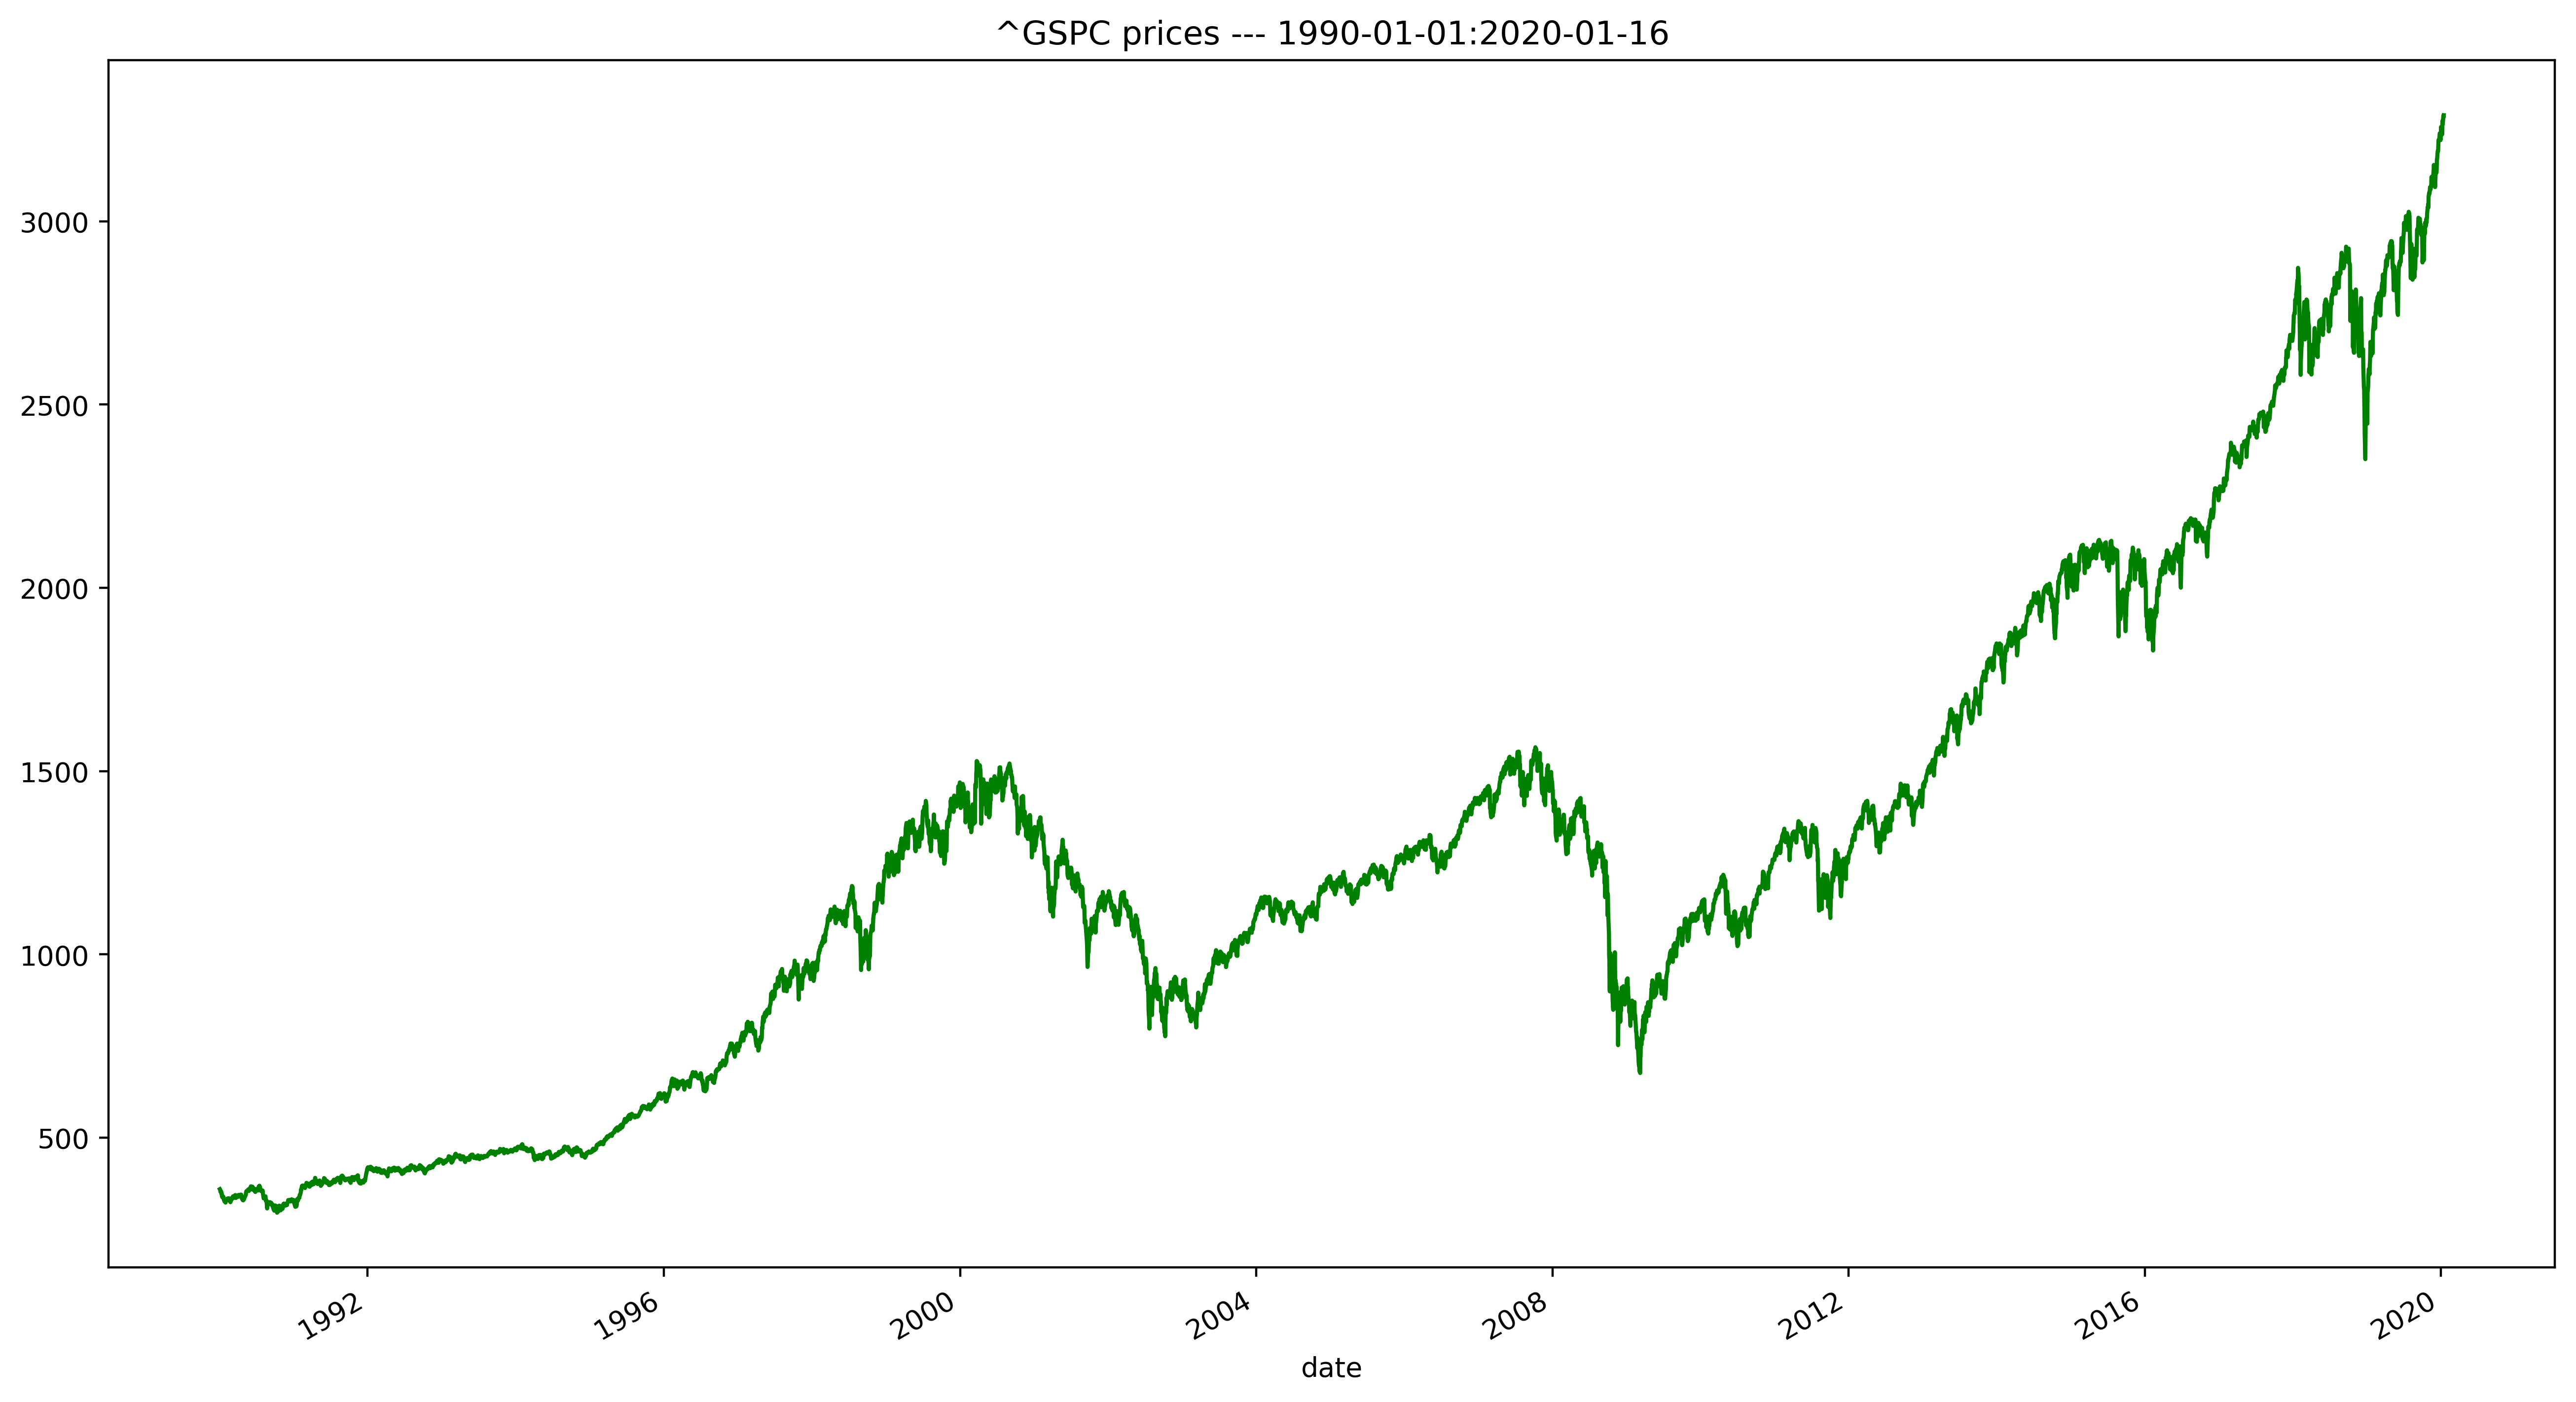

In [23]:
download_csv_data(ticker='^GSPC', 
                  start_date='1990-01-01', 
                  end_date='2020-01-16', 
                  freq='daily', 
                  path='data/SPY.csv')

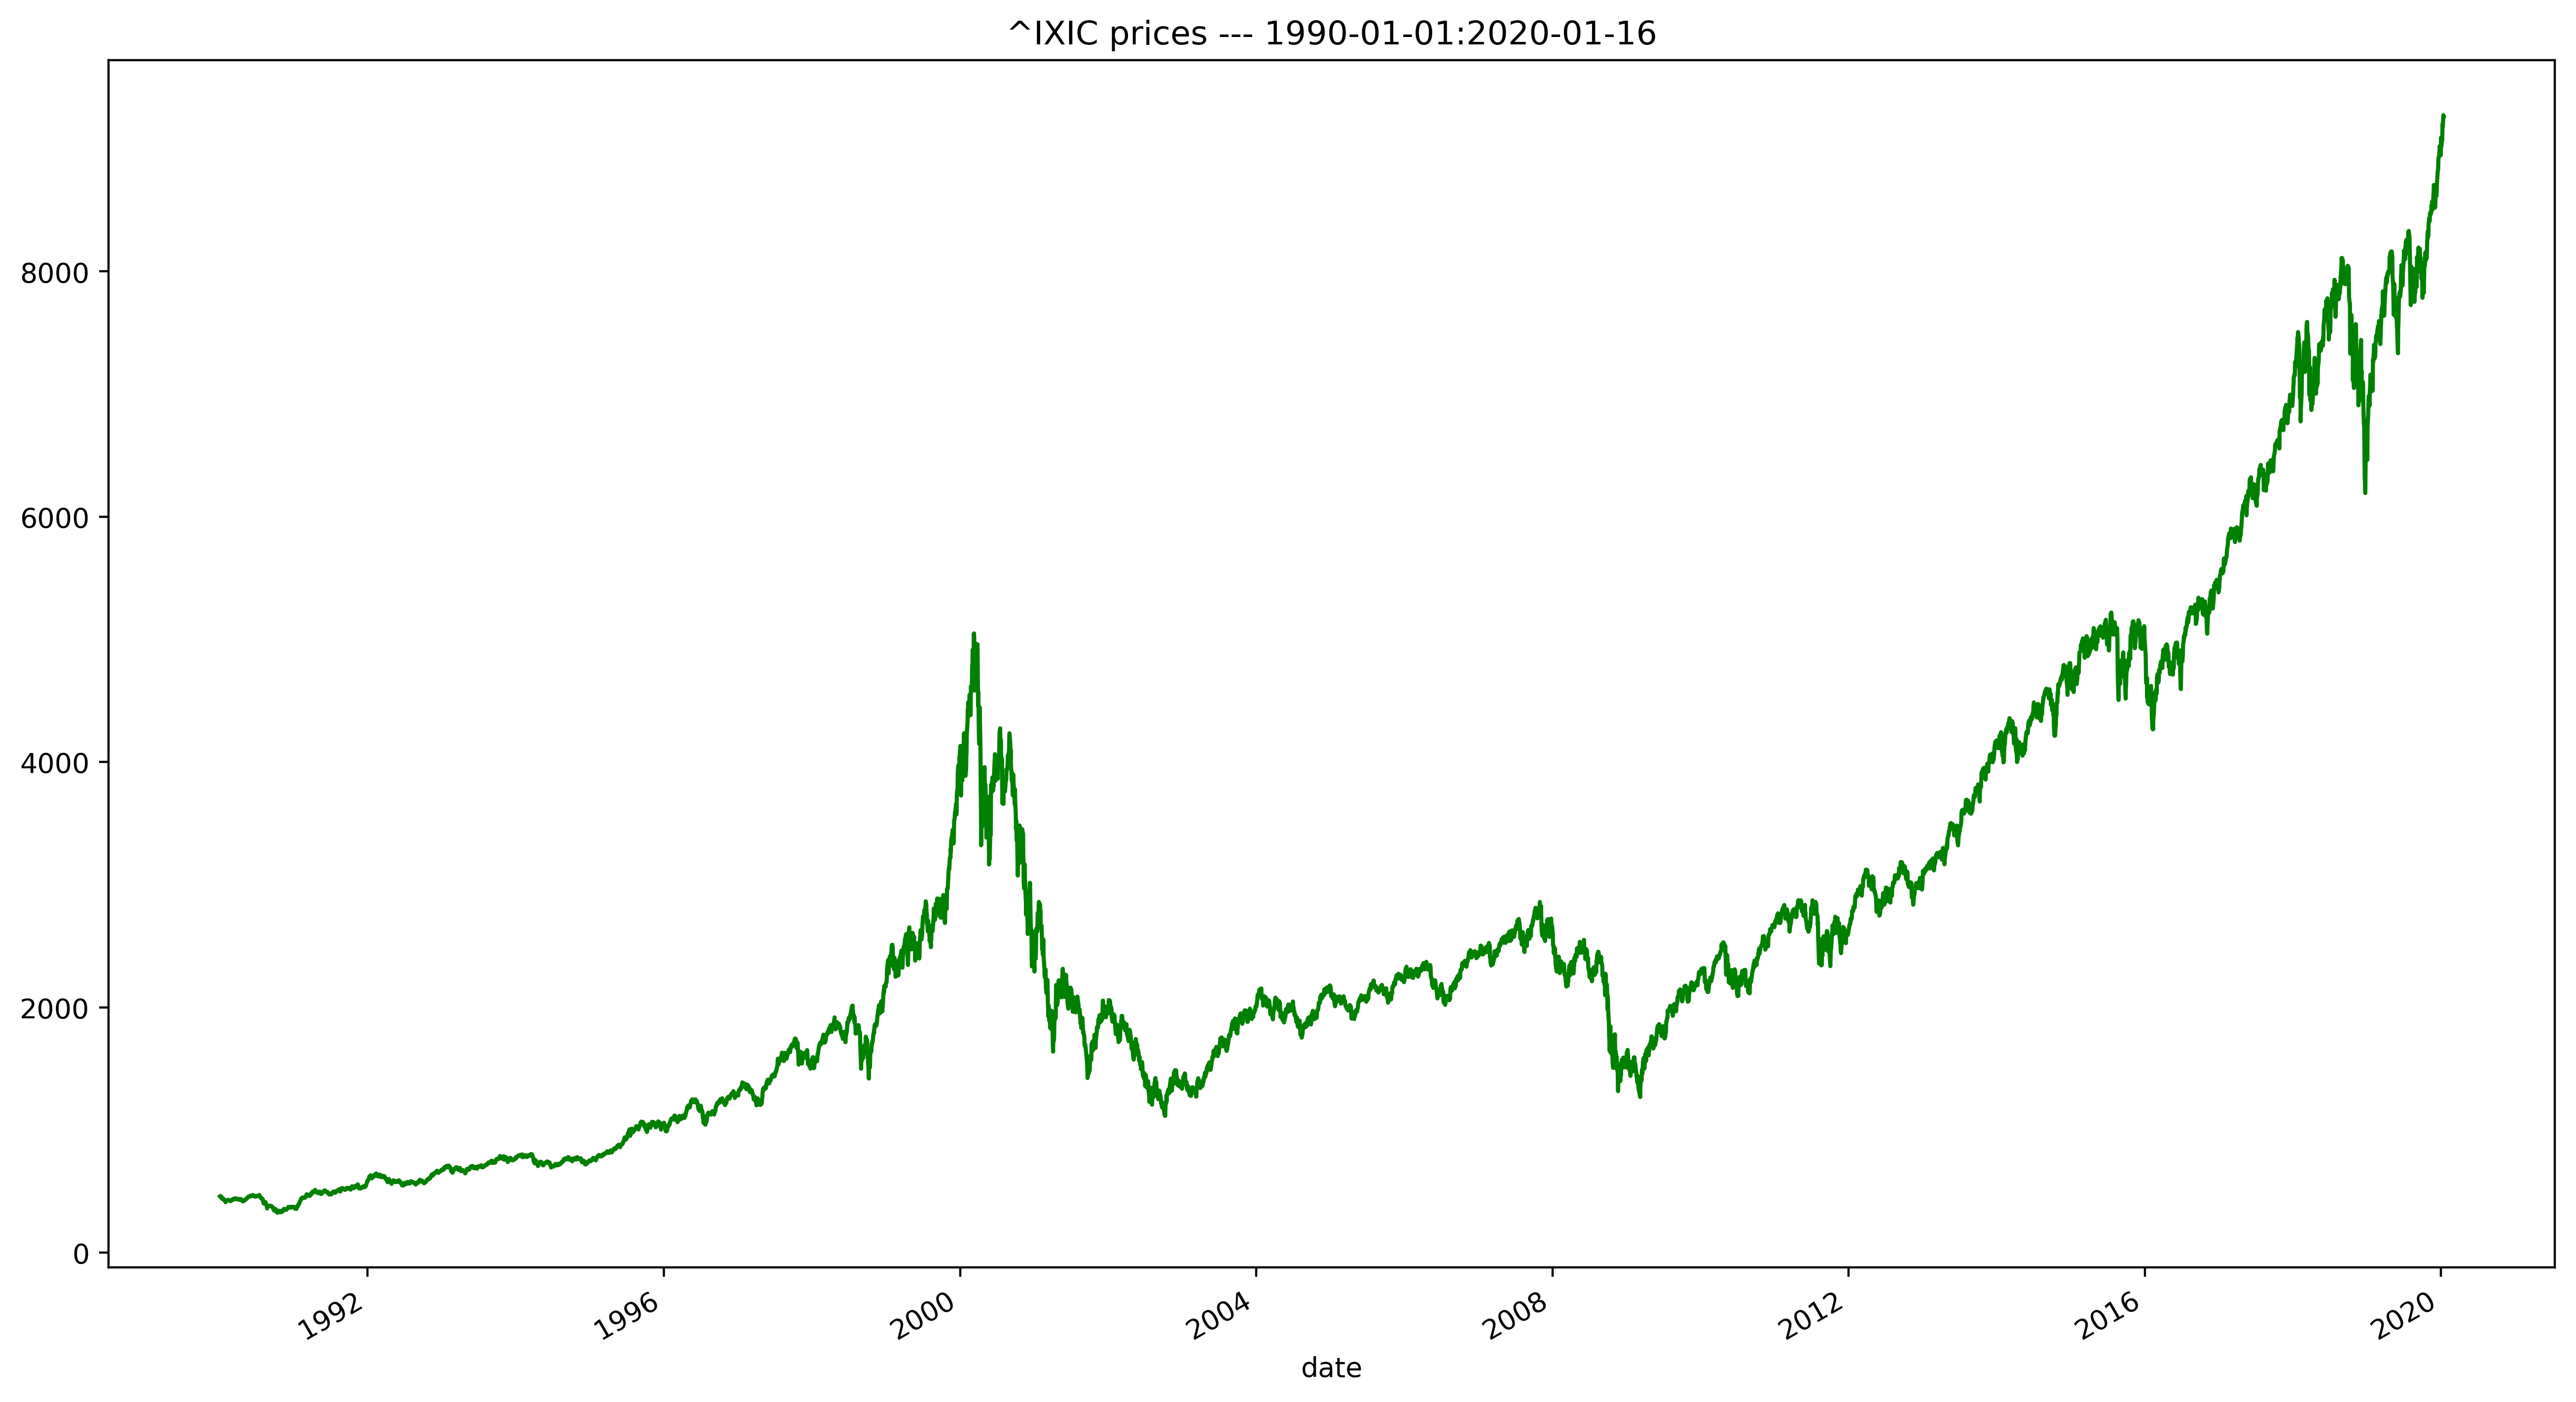

In [24]:
download_csv_data(ticker='^IXIC', 
                  start_date='1990-01-01', 
                  end_date='2020-01-16', 
                  freq='daily', 
                  path='data/QQQ.csv')

In [43]:
data = OrderedDict()

tikers = ["SPY", "QQQ"]

for tiker in tikers:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][["open","high","low","close","volume"]]
    #data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                  open        high         low       close     volume
date                                                                 
1990-01-02  353.399994  359.690002  351.980011  359.690002  162070000
1990-01-03  359.690002  360.589996  357.890015  358.760010  192330000
1990-01-04  358.760010  358.760010  352.890015  355.670013  177000000
1990-01-05  355.670013  355.670013  351.350006  352.200012  158530000
1990-01-08  352.200012  354.239990  350.540009  353.790009  140110000
                  open        high         low       close     volume
date                                                                 
1990-01-02  452.899994  459.299988  452.700012  459.299988  110720000
1990-01-03  461.100006  461.600006  460.000000  460.899994  152660000
1990-01-04  460.399994  460.799988  456.899994  459.399994  147950000
1990-01-05  457.899994  459.399994  457.799988  458.200012  137230000
1990-01-08  457.100006  458.700012  456.500000  458.700012  115500000


In [44]:
panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 7569 (major_axis) x 5 (minor_axis)
Items axis: SPY to QQQ
Major_axis axis: 1990-01-02 00:00:00+00:00 to 2020-01-15 00:00:00+00:00
Minor_axis axis: open to volume


# Simple Moving Average Strategy

In [45]:
# когда цена пересекает 20-дневный SMA вверх-покупайте акции x
# когда цена пересекает 20-дневный SMA вниз-продавайте акции
# мы можем иметь только максимум X акций в любой момент времени

## Определяем функции алгоритма

In [46]:
# Входные параметры:
ma_periods = 967
selected_stock = 'SPY'
n_stocks_to_buy = 1           # полож. число - покупка; отриц. число - продажа; 0 - продажа всего

In [47]:
def initialize(context):
    context.time = 0
    context.asset = symbol(selected_stock)
    
    # устанавливаем комиссию за сделку
    context.set_commission(commission.PerShare(cost=0, min_trade_cost=0))

In [48]:
def handle_data(context, data):
    
    
    
    # "Период прогрева" - это трюк, используемый для того, чтобы убедиться, что алгоритм имеет достаточно дней для расчета 
    # скользящей средней. Если мы используем несколько метрик с разной длиной окна, мы всегда должны брать самую длинную для разминки
    
    context.time += 1
    if context.time < ma_periods:
        return
    
    
    # Мы получаем доступ к историческим (и текущим) точкам данных с помощью данных.история. 
    # В этом примере мы получаем доступ к последним 20 дням. Данные (в случае одного актива) хранятся в виде панд.
    # Ряды, проиндексированные по времени
    
    price_history = data.history(context.asset, fields="price", bar_count=ma_periods, frequency="1d")
    
    
    # SMA является очень простой мерой, поэтому для расчета я просто беру среднее значение ранее доступных данных

    ma = price_history.mean()
    
    
    #  Я инкапсулировать логику торговой стратегии в случае, если заявление. Для доступа к текущим и предыдущим точкам 
    # данных я использую price_history[-2] и price_history[-1], соответственно. Чтобы увидеть, был ли кроссовер, 
    # я сравниваю текущую и предыдущую цены с MA и определяю, с каким случаем я имею дело (сигнал покупки/продажи). 
    # В случае отсутствия сигнала алгоритм ничего не делает
    
    # cross up
    if (price_history[-2] < ma) & (price_history[-1] > ma):
        order_target(context.asset, n_stocks_to_buy)
    # cross down
    elif (price_history[-2] > ma) & (price_history[-1] < ma):
        order_target(context.asset, 0)

    # save values for later inspection
    record(price=data.current(context.asset, 'price'),
           moving_average=ma)

In [49]:
perf = zipline.run_algorithm(start=datetime(1990, 1, 2, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 1, 15, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=100000,
                              handle_data=handle_data,
                              data=panel)

C:\Users\Alexey\Anaconda3\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
C:\Users\Alexey\Anaconda3\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


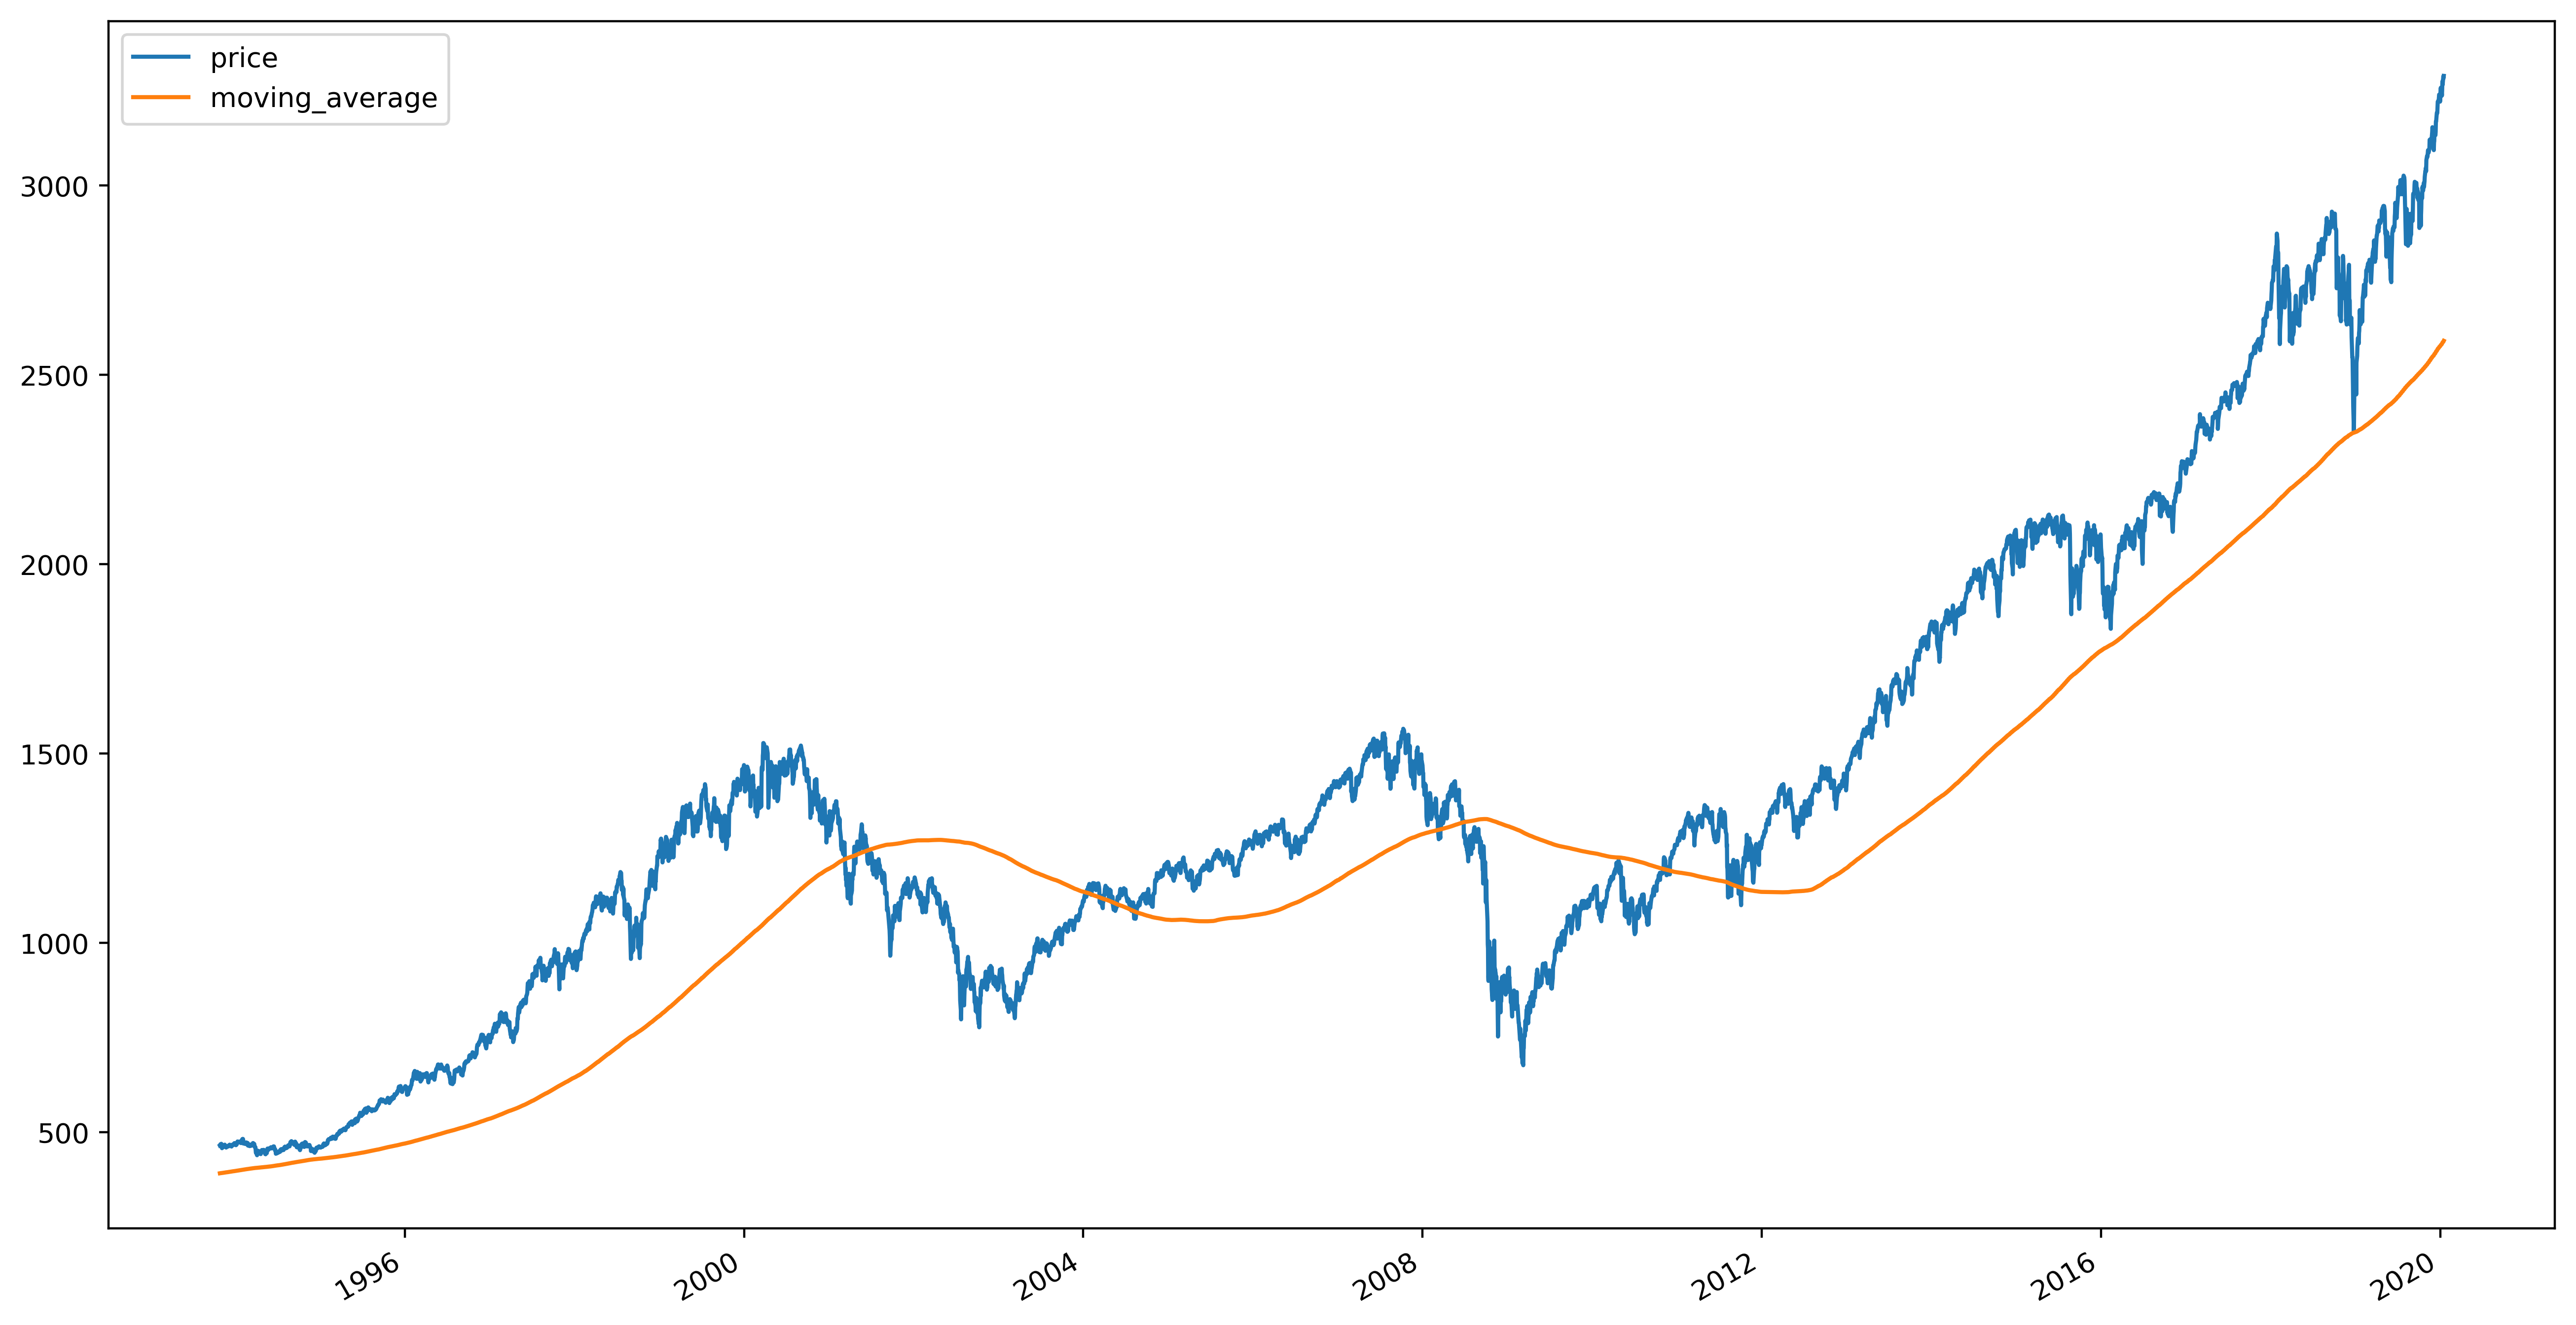

In [50]:
#fig, ax = plt.subplots(figsize=[16, 12])
    
# asset
perf[['price', 'moving_average']].plot()
#ax.set_ylabel('price in $')
#plt.legend()
plt.show()

In [51]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

# Nasdaq

In [52]:
# Входные параметры:
ma_periods = 967
selected_stock = 'QQQ'
n_stocks_to_buy = 1           # полож. число - покупка; отриц. число - продажа; 0 - продажа всего

In [53]:
def initialize(context):
    context.time = 0
    context.asset = symbol(selected_stock)
    
    # устанавливаем комиссию за сделку
    context.set_commission(commission.PerShare(cost=0, min_trade_cost=0))

In [54]:
def handle_data(context, data):
    
    
    
    # "Период прогрева" - это трюк, используемый для того, чтобы убедиться, что алгоритм имеет достаточно дней для расчета 
    # скользящей средней. Если мы используем несколько метрик с разной длиной окна, мы всегда должны брать самую длинную для разминки
    
    context.time += 1
    if context.time < ma_periods:
        return
    
    
    # Мы получаем доступ к историческим (и текущим) точкам данных с помощью данных.история. 
    # В этом примере мы получаем доступ к последним 20 дням. Данные (в случае одного актива) хранятся в виде панд.
    # Ряды, проиндексированные по времени
    
    price_history = data.history(context.asset, fields="price", bar_count=ma_periods, frequency="1d")
    
    
    # SMA является очень простой мерой, поэтому для расчета я просто беру среднее значение ранее доступных данных

    ma = price_history.mean()
    
    
    #  Я инкапсулировать логику торговой стратегии в случае, если заявление. Для доступа к текущим и предыдущим точкам 
    # данных я использую price_history[-2] и price_history[-1], соответственно. Чтобы увидеть, был ли кроссовер, 
    # я сравниваю текущую и предыдущую цены с MA и определяю, с каким случаем я имею дело (сигнал покупки/продажи). 
    # В случае отсутствия сигнала алгоритм ничего не делает
    
    # cross up
    if (price_history[-2] < ma) & (price_history[-1] > ma):
        order_target(context.asset, n_stocks_to_buy)
    # cross down
    elif (price_history[-2] > ma) & (price_history[-1] < ma):
        order_target(context.asset, 0)

    # save values for later inspection
    record(price=data.current(context.asset, 'price'),
           moving_average=ma)

In [55]:
perf = zipline.run_algorithm(start=datetime(1990, 1, 2, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 1, 15, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=1000,
                              handle_data=handle_data,
                              data=panel)

C:\Users\Alexey\Anaconda3\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
C:\Users\Alexey\Anaconda3\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


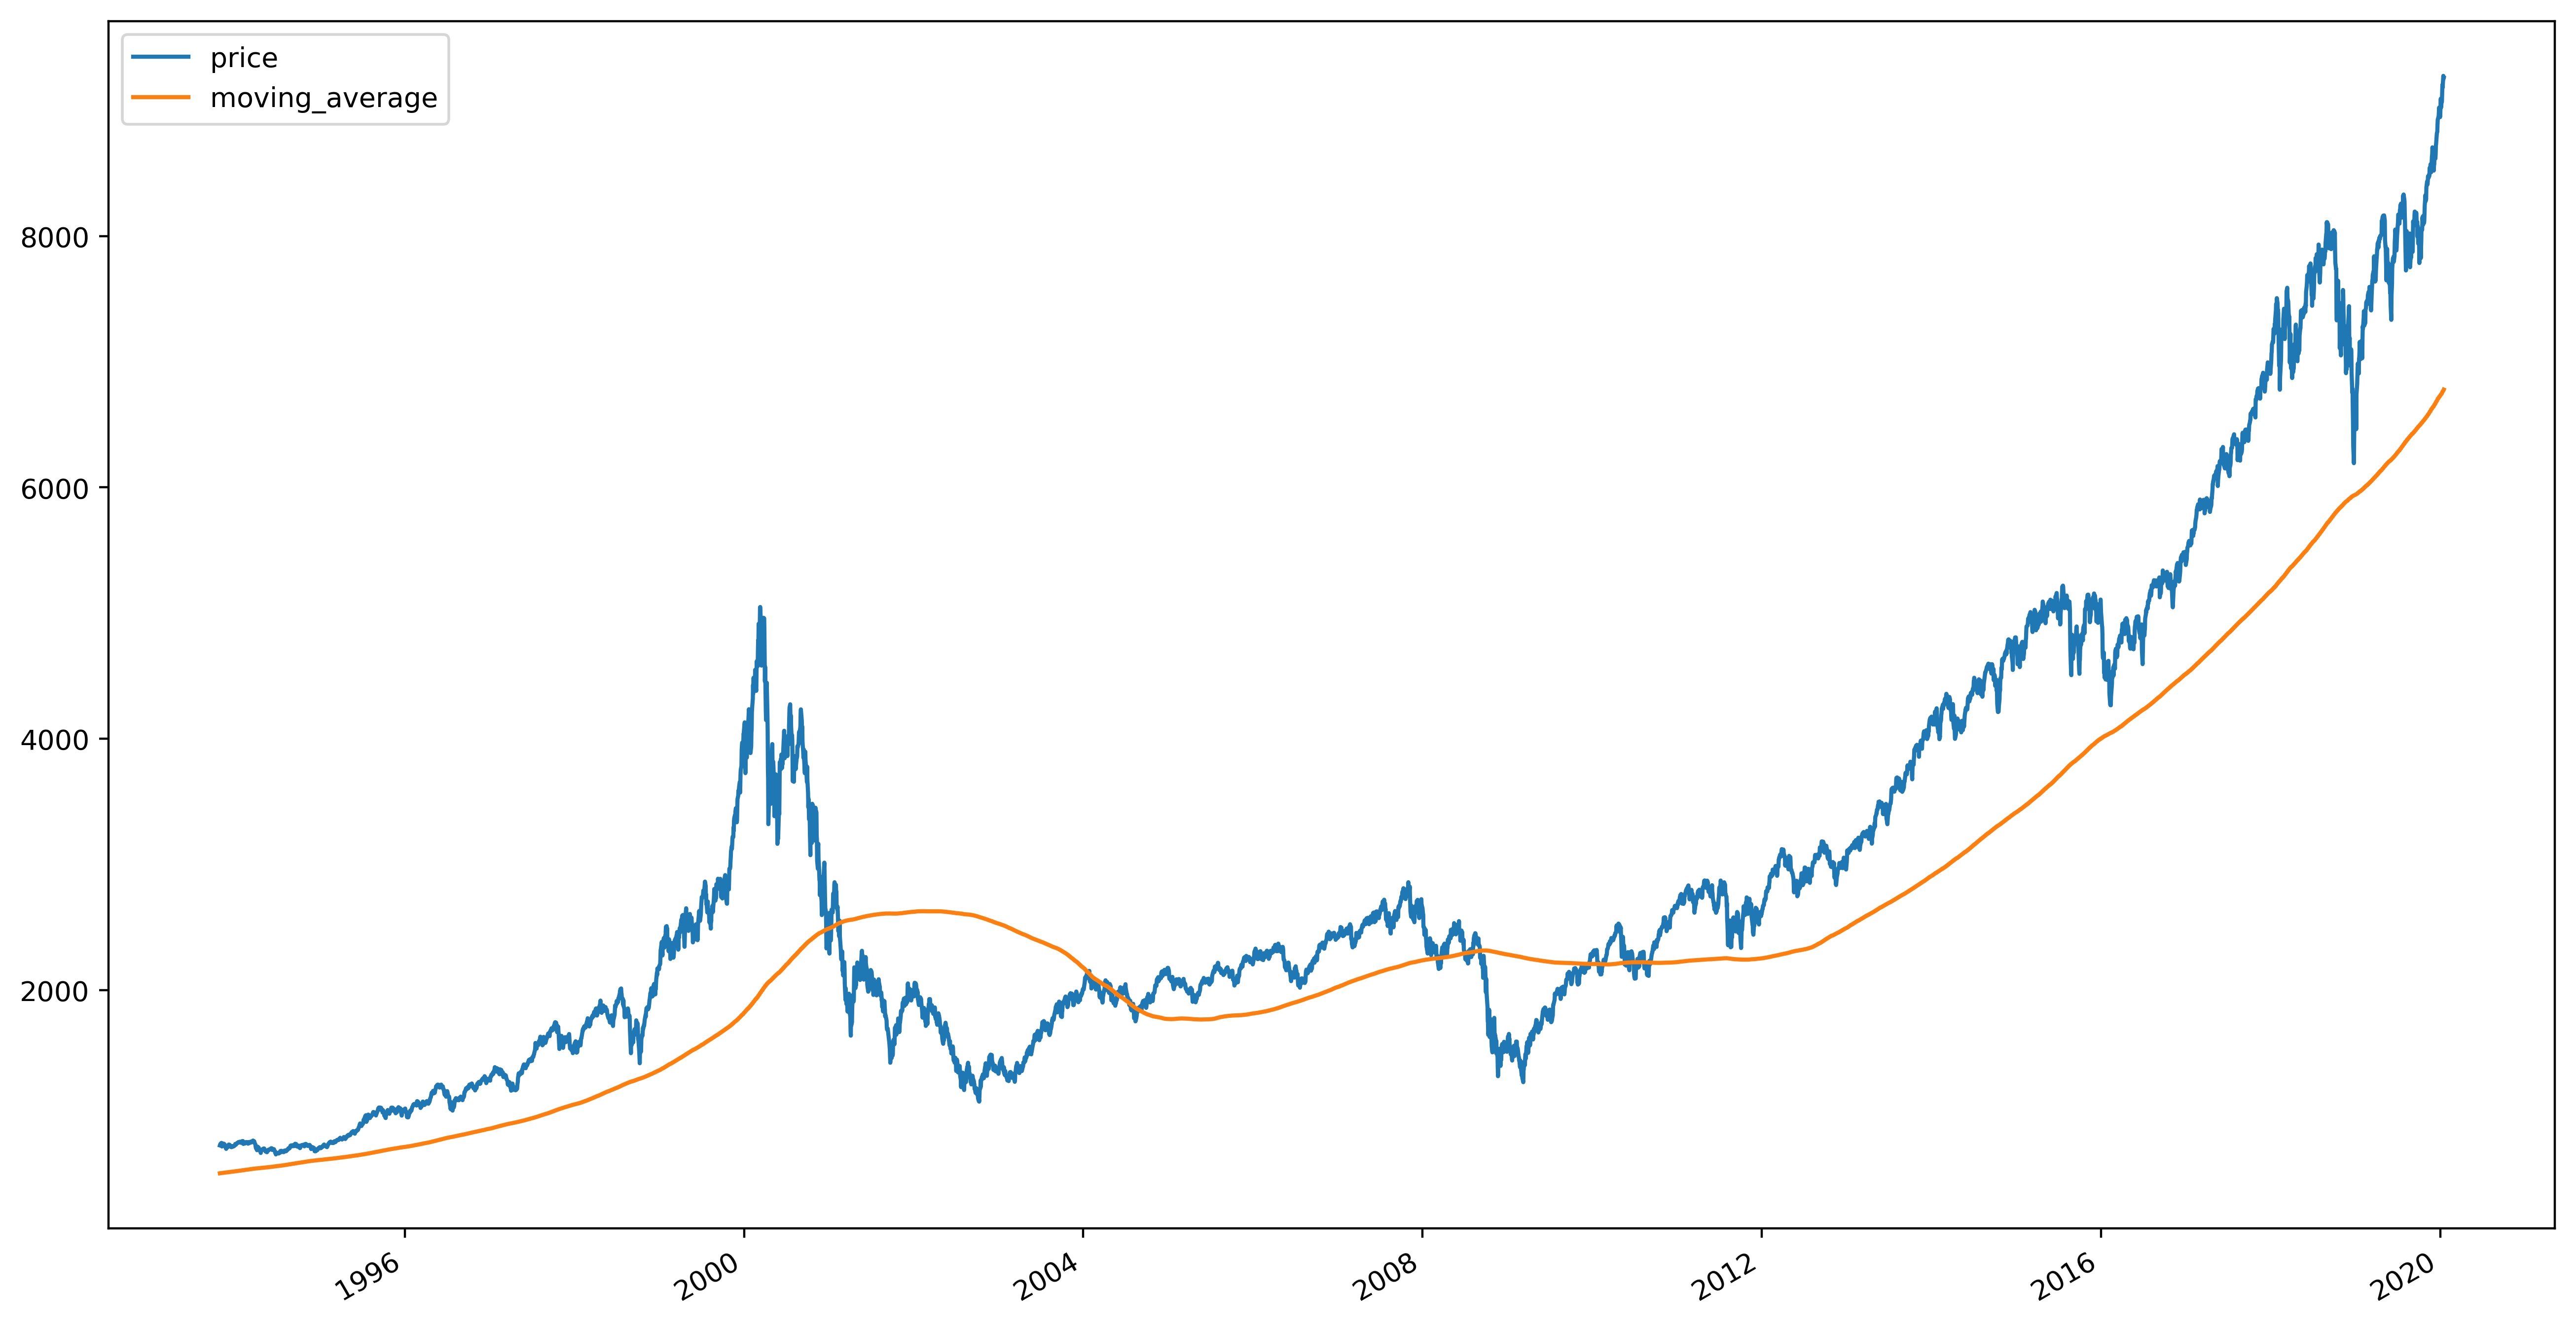

In [56]:
#fig, ax = plt.subplots(figsize=[16, 12])
    
# asset
perf[['price', 'moving_average']].plot()
#ax.set_ylabel('price in $')
#plt.legend()
plt.show()